In [1]:
import matplotlib.pyplot as pl
import numpy as np
import random
from PIL import Image

In [2]:
import sys
sys.path.append('../../')

# Test Majority Error
Majority Error is error when only the majority label is guessed.

In [17]:
run ../purity_metrics.py

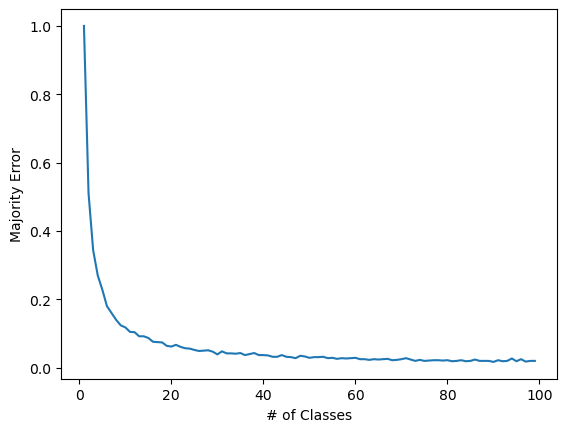

In [26]:
def test_majority_error(test_size=1000):
    
    classes = np.arange(100)
    
    def gen_labels(classes):
        y = []
        for i in range(test_size):
            y.append(random.choice(classes))
        return y
    
    data = []
    
    for i in range(1, len(classes)):
        y = gen_labels(classes[:i])
        data.append([i, majority_error(y)])
    
    data = np.array(data).T
    pl.plot(data[0], data[1])
    pl.xlabel('# of Classes')
    pl.ylabel('Majority Error')

test_majority_error()

# Test Gini Index

# Run ID3 on car-4 dataset 

In [3]:
import pandas as pd

In [4]:
cat ../../data/car-4/data-desc.txt

| label values

unacc, acc, good, vgood

| attributes

buying:   vhigh, high, med, low.
maint:    vhigh, high, med, low.
doors:    2, 3, 4, 5more.
persons:  2, 4, more.
lug_boot: small, med, big.
safety:   low, med, high.

| columns
buying,maint,doors,persons,lug_boot,safety,label


In [135]:
train = pd.read_csv(
    '../../data/car-4/train.csv',
    names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'label']
)
train

,buying,maint,doors,persons,lug_boot,safety,label
0,low,vhigh,4,4,big,med,acc
1,low,high,5more,4,med,high,vgood
2,vhigh,med,2,2,big,high,unacc
3,high,high,2,2,small,high,unacc
4,vhigh,low,3,2,big,low,unacc
...,...,...,...,...,...,...,...
995,low,med,2,more,small,low,unacc
996,high,low,4,more,med,low,unacc
997,med,low,5more,4,big,high,vgood
998,med,high,2,2,med,med,unacc


In [224]:
run ../ID3.py

In [225]:
model = ID3(train, 'label',
    # attribute_values={
    #     'buying':   ['vhigh', 'high', 'med', 'low'],
    #     'maint':    ['vhigh', 'high', 'med', 'low'],
    #     'doors':    ['2', '3', '4', '5more'],
    #     'persons':  ['2', '4', 'more'],
    #     'lug_boot': ['small', 'med', 'big'],
    #     'safety':   ['low', 'med', 'high']
    # },
    max_depth=7
)

In [226]:
# model

In [227]:
from ete3 import Tree, NodeStyle, TreeStyle, TextFace

def dict2tree(parent_branch, d):
    
    if type(d) is str:
        parent_branch.add_child(name=' '+d.upper())
        return
    
    for child in d:
        if '=' in child:
            dict2tree(parent_branch.add_child(name=' '+child+' '), d[child])

t = Tree()
dict2tree(t, model)

ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"

# ns = NodeStyle()
# ns.
t.render('mytree.png', w=1000, units="mm", tree_style=ts)
print(t.get_ascii(show_internal=True))
# Image.open('mytree.png')


                                                                / persons=2 - UNACC
                                                               |
                                                   / buying=high  persons=4 - ACC
                                                  |            |
                                                  |             \ persons=more - ACC
                                                  |
                                     / lug_boot=big  buying=low - UNACC
                                    |             |
                                    |             |- buying=med - ACC
                                    |             |
                                    |              \ buying=vhigh - UNACC
                            / doors=2 
                           |        |- lug_boot=med - ACC
                           |        |
                           |        |                / buying=high - UNACC
                           |        

In [228]:
def AND(*lists):
    l = len(lists[0])
    assert(np.all([len(i)==l for i in lists]))
    return [np.all(i) for i in np.array(lists).T]
AND([True, False], [True, True])

[True, False]

In [229]:
model['safety=high']

{'maint=high': {'doors=2': {'lug_boot=big': {'buying=high': {'persons=2': 'unacc',
     'persons=4': 'acc',
     'persons=more': 'acc'},
    'buying=low': 'unacc',
    'buying=med': 'acc',
    'buying=vhigh': 'unacc'},
   'lug_boot=med': 'acc',
   'lug_boot=small': {'buying=high': 'unacc',
    'buying=low': 'unacc',
    'buying=med': 'acc',
    'buying=vhigh': 'unacc'}},
  'doors=3': {'lug_boot=big': {'persons=2': 'unacc',
    'persons=4': 'acc',
    'persons=more': 'acc'},
   'lug_boot=med': 'acc',
   'lug_boot=small': {'buying=high': {'persons=2': 'unacc',
     'persons=4': 'acc',
     'persons=more': 'acc'},
    'buying=low': 'unacc',
    'buying=med': 'unacc',
    'buying=vhigh': 'unacc'}},
  'doors=4': {'lug_boot=big': {'persons=2': 'unacc',
    'persons=4': 'acc',
    'persons=more': 'acc'},
   'lug_boot=med': {'buying=high': {'persons=2': 'unacc',
     'persons=4': 'acc',
     'persons=more': 'acc'},
    'buying=low': 'unacc',
    'buying=med': {'persons=2': 'unacc',
     'perso

In [230]:
train[
    AND(
        train.safety=='high',
        train.maint=='high',
        train.doors=='5more',
        train.lug_boot=='med',
        train.persons=='4'
    )
]

,buying,maint,doors,persons,lug_boot,safety,label
1,low,high,5more,4,med,high,vgood
87,high,high,5more,4,med,high,acc


In [231]:
len(train)

1000

In [232]:
errors = 0
def check_example(example, node):
    global errors
    if type(node)==str:
        print(node, example['label'])
        # assert(example['label']==node)
        if not example['label']==node:
            errors+=1
        return node
    
    keys = list(node.keys())
    
    attribute = keys[0].split('=')[0]
    
    value = example[attribute]
    
    # print(attribute+'='+value, example.label)
    return check_example(example, node[attribute+'='+value])

preds = []
for index, row in train.iterrows():
    # print(index)
    preds.append(check_example(row, model))
    
errors

acc acc
acc vgood


AssertionError: 